In [124]:
import pandas as pd
import numpy as np
import copy
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


from IPython.core.interactiveshell import InteractiveShell  # print all outputs
InteractiveShell.ast_node_interactivity = "all"

#plt.style.use('fivethirtyeight') 
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['text.color'] = 'k'
%matplotlib inline

In [125]:
SEED = 1234
random.seed(SEED)

In [126]:
#Finally, we load processed data after having selected the most relevant features 
df_train = pd.read_csv('data/data_to_predict.csv')
df_original = pd.read_csv("data/train.csv")
df_test = pd.read_csv('data/processed_discrete_test_data.csv')

In [127]:
target_variable = 'aircon_sum_target_next14d'
input_variables = df_train.columns[(df_train.columns!= target_variable) & (df_train.columns!= 'DATE') & (df_train.columns!= 'SITE_ID')]

X = df_train[input_variables]
y = df_train[target_variable]


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=SEED, shuffle=True)
cv= StratifiedKFold(n_splits=10, shuffle=True)

## Metric

##### The evaluation metric is defined as "Weighted Recall", computed considering the 10 sites with highest fault probability as predicted with fault weighted by N_TRANSPORTED_SITES column. The thresholding level is therefore defined day by day by the top sites and not by a fixed threshold level.



In [129]:
def add_date_and_pred(df_original, X_test, y_pred):
   
    X_test_date = X_test.copy()
    X_test_date["DATE"] = df_original.loc[X_test.index]["DATE"]
    X_test_date["prediction"] = 1
    X_test_date["prediction"] = X_test_date["prediction"].multiply(y_pred)
   
    return X_test_date

In [130]:
def add_date_and_target (df_original, X_test, y_test):
   
    X_test_date = X_test.copy()
    X_test_date["DATE"] = df_original.loc[X_test.index]["DATE"]
    X_test_date['aircon_sum_target_next14d'] = 1
    X_test_date['aircon_sum_target_next14d'] = X_test_date['aircon_sum_target_next14d'].multiply(y_test)
   
    return X_test_date

In [131]:
def metric(df_original, X_test, y_test,y_pred ):

    y_pred = [i[1] for i in y_pred ]
    y_pred = np.array(y_pred)
    
    test_df_with_target = add_date_and_target (df_original, X_test, y_test)
    test_df_with_target['SITE_ID'] = test_df_with_target.index


    submission_dataset = add_date_and_pred(df_original, X_test, y_pred)
    submission_dataset['SITE_ID'] = submission_dataset.index

    eval_df = test_df_with_target[['SITE_ID' , 'DATE' , 'N_TRANSPORTED_SITES' , 'aircon_sum_target_next14d' ]].copy()

    submission_dataset = submission_dataset.merge(eval_df, on=['SITE_ID' , 'DATE' ])

    recalls = []

    #compute daily performance

    for date, daily_df in submission_dataset.groupby(['DATE' ]):

        daily_df=daily_df.copy()

        daily_df['final_prediction' ] = 0

        daily_df['NORM_N_TRANSPORTED_SITES' ] = daily_df['N_TRANSPORTED_SITES_x']/daily_df['N_TRANSPORTED_SITES_x' ].max()

        daily_df['weighted_prediction' ] = 0.8* daily_df['prediction' ] + 0.2*daily_df['NORM_N_TRANSPORTED_SITES' ]

        daily_df = daily_df.sort_values(by=['weighted_prediction' ], ascending=False)

        daily_df = daily_df.reset_index(drop=True)

        daily_df.loc[0:10, 'final_prediction' ] = 1

        daily_recall = recall_score(y_true=daily_df['aircon_sum_target_next14d' ], y_pred=daily_df['final_prediction' ])

        recalls.append(daily_recall)

    final_metric= np.mean(recalls)

    return final_metric

## Oversampling

##### Since this dataset is heavily unbalanced, we decided to oversample the minority class (target = 1) in the training dataset. This has slighlty improved our model performance. In the cell below, we show the number of samples belonging to the target class before and after oversampling.
 

In [132]:
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=0.2)

# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

print("Number of samples belonging to class 0 and 1 before oversampling " + str((Counter(y_train))))
print("Number of samples belonging to class 0 and 1 after oversampling "+ str((Counter(y_train_over))))

Number of samples belonging to class 0 and 1 before oversampling Counter({0: 489868, 1: 2832})
Number of samples belonging to class 0 and 1 after oversampling Counter({0: 489868, 1: 97973})


### Tuning hyperparameters

##### We chose Random Forest as model to predict data. In the cell below we have found the highest effective combination of hyperparameters. Parameters we have tuned are the number of estimators, max depth and min. sample leaf.

In [ ]:
estimators = [250,300,350]
max_depths = [30,35,40]
min_sample_leaf = [2,5,10]

from random import randrange

models = []

for i in range(4):
    
    for j in range(3):
     

        m_s_l = min_sample_leaf[randrange(3)]

    
        model = RandomForestClassifier(n_estimators= estimators[i], max_depth= max_depths[j], 
                                           oob_score=False, class_weight= "balanced",
                                           random_state = SEED,
                                           max_features = "sqrt",min_samples_leaf = m_s_l)
        models.append(model)
    
for model in models :
    
    model.fit(X_train_over,y_train_over)
    yp = model.predict(X_test)
    y_pred = model.predict_proba(X_test)
    print("========================================")
    print("%40s"%model)
    print("\t      Precision %.3f"%precision_score(y_test, yp))
    print("\t      Recall    %.3f"%recall_score(y_test, yp))
    print("\t      F1        %.3f"%f1_score(y_test, yp))
    print("\t WEIGHTED RECALL %.3f"%metric(df_original,X_test,y_test, y_pred))
    

### The Model Chosen

##### The most effective hyperparameters that seemed to give a better performance are:
###### Num. of estimators = 300
###### Max depth = 35
###### Min sample leaf = 5

In [17]:
model = RandomForestClassifier(n_estimators= 250, max_depth= 40, 
                                           oob_score=False, class_weight= "balanced",
                                           random_state = SEED,
                                           max_features = "sqrt",min_samples_leaf = 5)

We have confirmed our model also through cross-validation

In [18]:
model.fit(X_train_over,y_train_over)

RandomForestClassifier(class_weight='balanced', max_depth=40,
                       max_features='sqrt', min_samples_leaf=5,
                       n_estimators=250, random_state=1234)

In [133]:
X_train_over

,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,...,skew_fire/smoke_alarms_prev14d,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,CELL_TYPE
0,1.0,1,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,0
1,5.0,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.18,0.0,-1.210000,-1.210000,-1.212308,-0.080000,-1.210000,0
2,5.0,5,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,0
3,1.0,6,0.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,...,0.00,0.0,0.00,0.0,-1.212308,-1.210000,-1.212308,-1.210000,-1.210000,0
4,1.0,4,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,...,0.11,0.0,0.00,0.0,-1.212308,-1.160000,-1.212308,-1.210000,-1.210000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587836,1.0,3,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,-1.210000,-1.210000,-1.212308,-1.212308,-1.210000,0
587837,1.0,3,2.0,3.0,4.0,4.0,4.0,0.0,0.0,0.0,...,0.00,0.0,0.00,-0.1,-1.212308,-1.210000,-1.212308,-1.210000,-1.110000,0
587838,7.0,7,1.0,1.0,4.0,4.0,4.0,1.0,0.0,0.0,...,0.00,0.0,0.05,-0.2,-1.212308,-1.212308,-1.212308,-0.960000,-1.200000,0
587839,5.0,0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,0.0,...,0.00,0.0,0.00,0.0,-1.210000,-1.210000,-1.212308,-1.210000,-1.210000,0


In [93]:
yp = model.predict(X_test)
y_pred = model.predict_proba(X_test)
print("========================================")
print("\t      Precision %.3f"%precision_score(y_test, yp))
print("\t      Recall    %.3f"%recall_score(y_test, yp))
print("\t      F1        %.3f"%f1_score(y_test, yp))
print("\t WEIGHTED RECALL %.3f"%metric(df_original,X_test,y_test, y_pred))

	      Precision 0.731
	      Recall    0.825
	      F1        0.775


C:\Users\Francesco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 WEIGHTED RECALL 0.849


##### Here the most relevant features used by our model are plotted

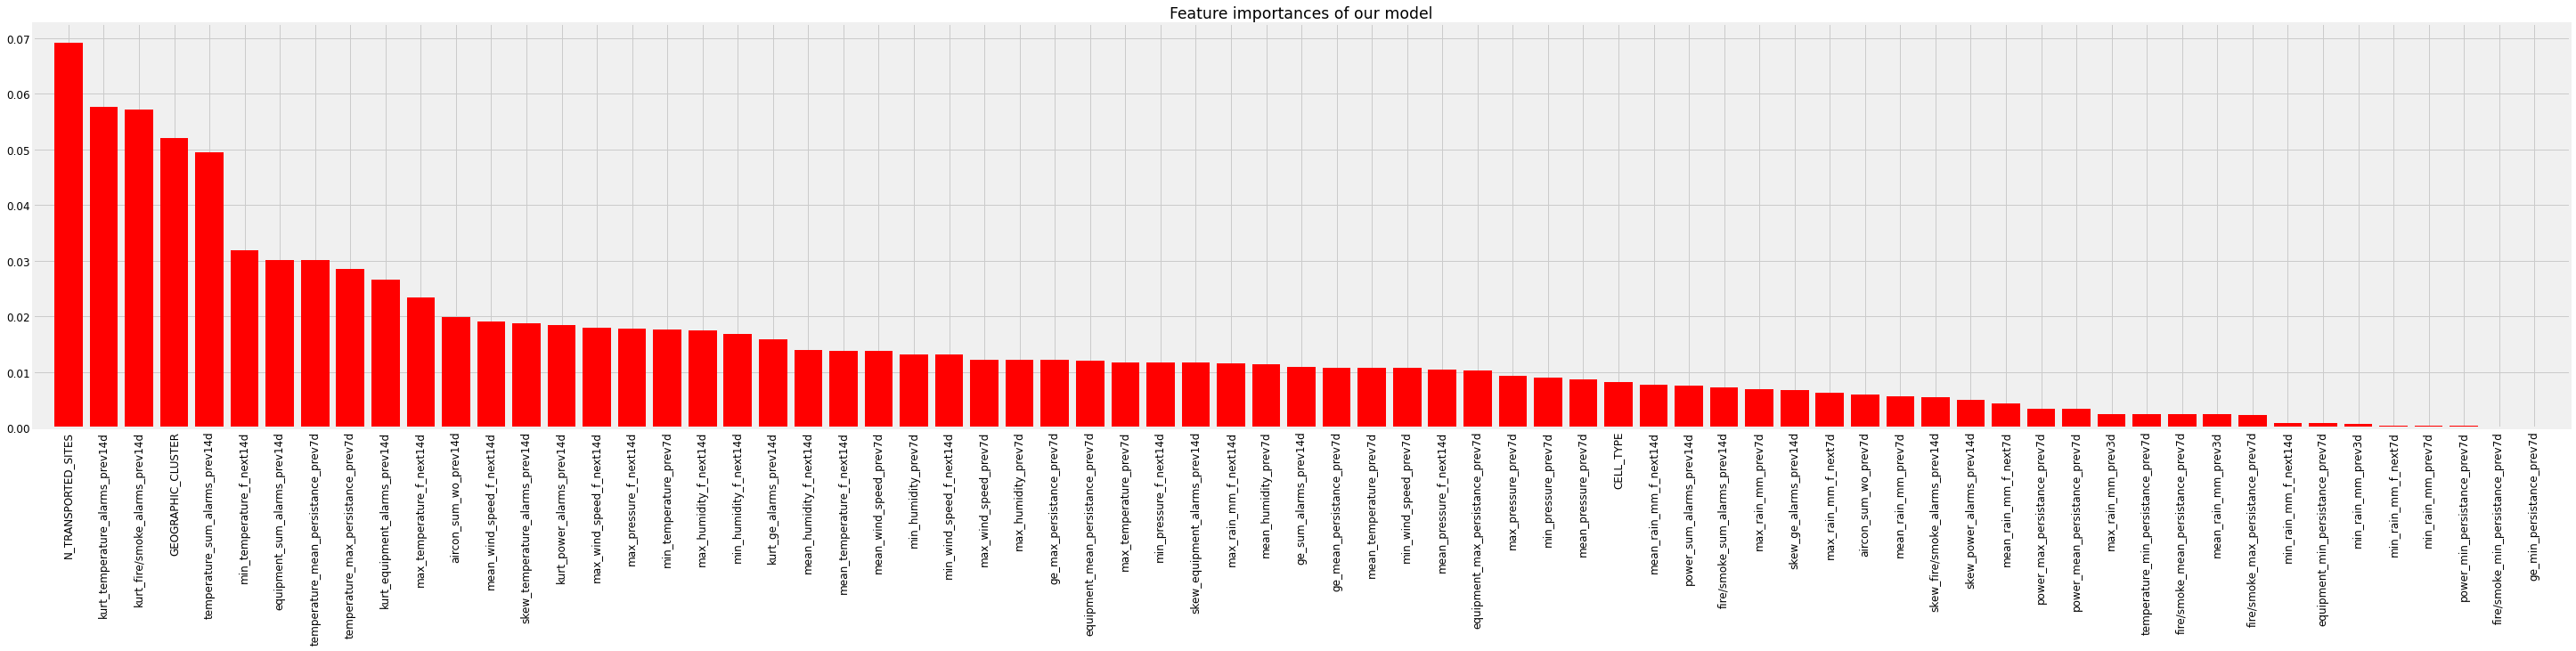

In [16]:
plot_idx = 1
plt.subplots(1,1,figsize=(40,10*1))
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
   
feature_importances = []
    
    # importance of features
importances = model.feature_importances_
    # indeces of the variables
indices = np.argsort(importances)[::-1]
feature_importances.append(X.columns[indices[:20]])
    
plt.subplot(1,1,plot_idx)
plt.title("Feature importances of our model")
plt.xticks(range(X.shape[1]),X.columns[indices],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.bar(range(X.shape[1]), importances[indices], color="r")
plot_idx = plot_idx + 1

plt.tight_layout(pad=0.1, w_pad=1, h_pad=1)
plt.show();

### Predicting the Test

#### From the feature selection notebook we decided to keep the following features. Therfore drop the others also in the df_test

In [134]:
input_variables = df_test.columns[(df_test.columns!= 'DATE') & (df_test.columns!= 'SITE_ID')]
test_to_predict = df_test[input_variables]

In [136]:
ms_to_delete = []

alarms = ['equipment', 'fire/smoke', 'ge', 'power', 'temperature']
weathers = ['temperature', 'humidity', 'wind_speed', 'pressure']
operators = ['mean', 'max', 'min']

#sum
for d in ['7', '3']:
    for a in alarms:
        ms_to_delete.append(a + '_sum_alarms_prev'+ d +'d')

#weather prev
for w in weathers:
    for o in operators:
        ms_to_delete.append(o + '_' + w + '_prev3d')
        
#weather future
for w in weathers:
    for o in operators:
        ms_to_delete.append(o + '_' + w + '_f_next7d')

#persistance
for a in alarms:
    for o in operators:
        ms_to_delete.append(a + '_' + o +'_persistance_prev3d')


print("We are going to remove " +str(len(ms_to_delete))+ " attributes")

We are going to remove 49 attributes


In [137]:
test_to_predict = test_to_predict.drop(ms_to_delete, axis=1)

### Generation of the prediction file

Reorder the test_to_predict features

In [138]:
test_to_predict = test_to_predict[X_train_over.columns]

In [139]:
df = pd.DataFrame()
df['SITE_ID'] = df_test['SITE_ID']
df['DATE'] = df_test['DATE']
test_pred = model.predict_proba(test_to_predict)
test_pred = [i[1] for i in test_pred ]
test_pred = np.array(test_pred)

In [123]:
df["prediction"] = test_pred

df.to_csv(path_or_buf = 'data/predictions.csv',index = False)